In [23]:
import gsw
import numpy as np
import xarray as xr
from scipy import stats
from pathlib import Path
from scipy import interpolate
import matplotlib.pyplot as plt
from main import paths, idx_1d, LAT_DEG, lx
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import LinearSegmentedColormap
from main_valid import EUC_depths, plot_eq_velocity
from main_valid import open_tao_data, plot_tao_timeseries, cor_scatter_plot

# Path to save figures, save data and OFAM model output.
fpath, dpath, xpath, lpath, tpath = paths()

# Saved data frequency (1 for monthly and 0 for daily data).
T = 1

# Open dataset of TAO data at the frequency.
ds = open_tao_data(frq=lx['frq_short'][T], dz=slice(10, 360))
dt = xr.open_dataset(dpath.joinpath('ofam_ocean_u_EUC_int_transport.nc'))

INFO: Opening TAO mon data. Depth=slice(10, 360, None). SI=True


In [24]:
z1 = 25
z2 = 350
dt = xr.open_dataset(dpath.joinpath('ofam_ocean_u_EUC_int_transport.nc'))
dt = dt.sel(st_ocean=slice(z1, z2))

# Saved data frequency (1 for monthly and 0 for daily data).
T = 1

# Open dataset of TAO data at the frequency.
ds = open_tao_data(frq=lx['frq_short'][T], dz=slice(z1, z2))

dk = 5  # Distance between depth layers [5 m].

# Add transport between depths.
dtt = dt.uvo.isel(st_ocean=0).copy()*np.nan

# Add velocity between depths.
dv = dt.u.isel(st_ocean=0).copy()*np.nan

for i in range(3):
    dq = dt.sel(xu_ocean=lx['lons'][i])
    v_max, depth_vmax, depth_end = EUC_depths(dq.u, dq.st_ocean, i, log=False)
    for t in range(len(dt.Time)):
        if not np.isnan(depth_end[t]):
            # Transport
            tmp1 = dt.uvo.isel(xu_ocean=i, Time=t)
            dtt[t, i] = tmp1.where(tmp1 > 0).sel(
                st_ocean=slice(z1, depth_end[t].item())).sum(
                    dim='st_ocean').item()

            # Velocity
            tmp2 = dt.u.isel(xu_ocean=i, Time=t)
            dv[t, i] = (tmp2*dk).where(tmp2 > 0).sel(
                st_ocean=slice(z1, depth_end[t].item())).sum(
                    dim='st_ocean').item()

INFO: Opening TAO mon data. Depth=slice(25, 350, None). SI=True


INFO: slope=0.36, intercept=1.44, r=0.88, p=0.00, std_err=0.01
INFO: slope=0.40, intercept=-6.53, r=0.87, p=0.00, std_err=0.01
INFO: slope=0.30, intercept=-12.48, r=0.85, p=0.00, std_err=0.01


SpearmanrResult(correlation=0.9232554000598187, pvalue=1.1485900817810265e-126)
SpearmanrResult(correlation=0.8629855215799722, pvalue=2.6350714041726534e-85)
SpearmanrResult(correlation=0.8137961197306669, pvalue=3.10553813254588e-76)


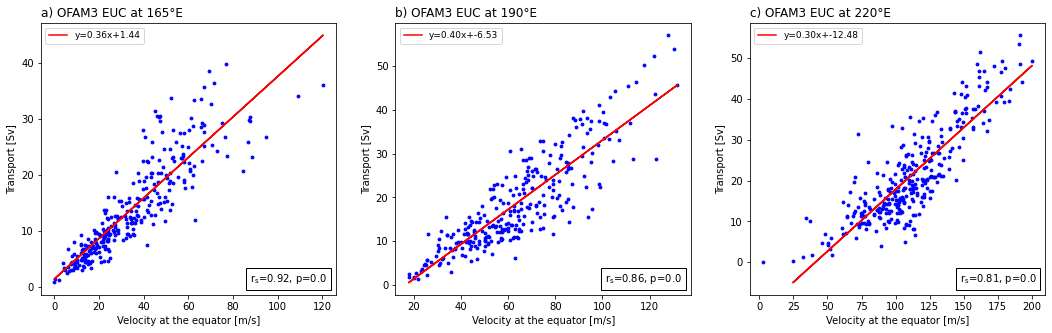

In [25]:
fig = plt.figure(figsize=(18, 5))
m, b = np.zeros(3), np.zeros(3)
for i in range(3):
    m[i], b[i] = cor_scatter_plot(fig, i+1, dv.isel(xu_ocean=i),
                                  dtt.isel(xu_ocean=i)/1e6,
                                  name='{}OFAM3 EUC at {}°E'.format(
                                      lx['l'][i], lx['lons'][i]),
                                  ylabel="Transport [Sv]",
                                  xlabel="Velocity at the equator [m/s]",
                                  cor_loc=4)

In [26]:
ds_sum = [ds[i].u_1205.isel(depth=0)*np.nan for i in range(3)]
for i in range(3):
    depth_end_tao = EUC_depths(ds[i].u_1205, ds[i].depth, i)[2]
    for t in range(len(ds[i].u_1205.time)):
        if not np.isnan(depth_end_tao[t]):
            tmp = ds[i].u_1205.isel(time=t).sel(depth=slice(z1,
                                                            depth_end_tao[t]))
            ds_sum[i][t] = (tmp*dk).where(tmp > 0).sum(dim='depth').item()

INFO: TAO/TRITION 165: v_bnd=0.1 count=58 tot=203, skipped=140 empty=5 eps=0.05.
INFO: TAO/TRITION 190: v_bnd=0.1 count=170 tot=340, skipped=134 empty=36 eps=0.05.
INFO: TAO/TRITION 220: v_bnd=0.1 count=188 tot=311, skipped=92 empty=31 eps=0.05.


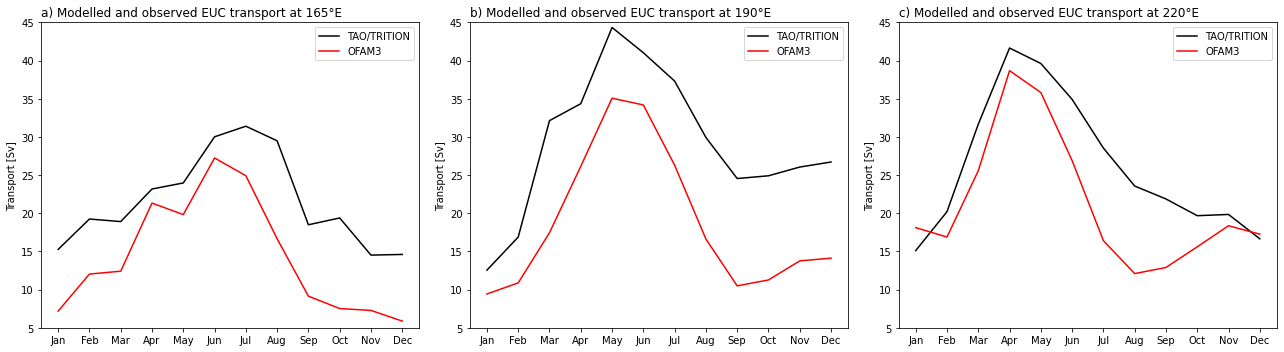

In [31]:
# Time index bounds where OFAM and TAO are available.
time_bnds_ofam = [[10*12+3, 27*12+1], [7*12+4, -1], [9*12+4, -1]]
time_bnds_tao = [[0, -1], [0, 24*12+8], [0, 22*12+8]]

fig = plt.figure(figsize=(18, 5))
for i in range(3):
    # TAO/TRITION slice.
    du = ds_sum[i].isel(time=slice(time_bnds_tao[i][0], time_bnds_tao[i][1]))

    # Rename TAO time array (so it matches OFAM3).
    duc = du.rename({'time': 'Time'})

    # Convert TAO time array to monthly, as ofam/tao days are different.
    duc.coords['Time'] = duc['Time'].values.astype('datetime64[M]')

    # OFAM3 slice.
    dtx = dtt.sel(xu_ocean=lx['lons'][i])
    dtx = dtx.isel(Time=slice(time_bnds_ofam[i][0], time_bnds_ofam[i][1]))
    dtx = dtx.groupby('Time.month').mean()
    duc = (duc*m[i] + b[i]).groupby('Time.month').mean()

    SV = 1e6
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title('{}Modelled and observed EUC transport at {}°E'.format(
        lx['l'][i], lx['lons'][i]), loc='left')
    ax.plot(dux.month, duc, color='k', label='TAO/TRITION')
    ax.plot(dtc.month, dtx/SV, color='red', label='OFAM3')

    ax.set_ylabel('Transport [Sv]')
    ax.set_xticks(np.arange(1, len(lx['mon'])+1))
    ax.set_xticklabels(lx['mon'])
    ax.set_ylim(ymin=5, ymax=45)
    ax.legend(loc=1)
plt.tight_layout()
plt.savefig(fpath.joinpath('tao', 'EUC_transport_regression_mon.png'))

In [ ]:
dm = 'ocean_temp_1981-2012_climo.nc'